In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import re
import cv2
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
image_dir = '../dataset/dataset/Raw Data/'

In [3]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [4]:
SIZE = 256
high_img = []
path = '../dataset/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

100%|██████████| 855/855 [00:20<00:00, 41.80it/s]


In [5]:
low_img = []
path = '../dataset/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:17<00:00, 47.59it/s]


In [6]:
augmented_dir='../dataset/augmented_imgs' 
os.makedirs(augmented_dir, exist_ok=True)

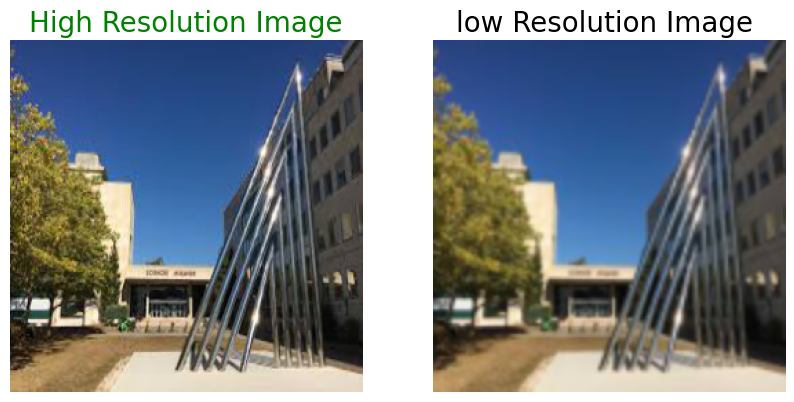

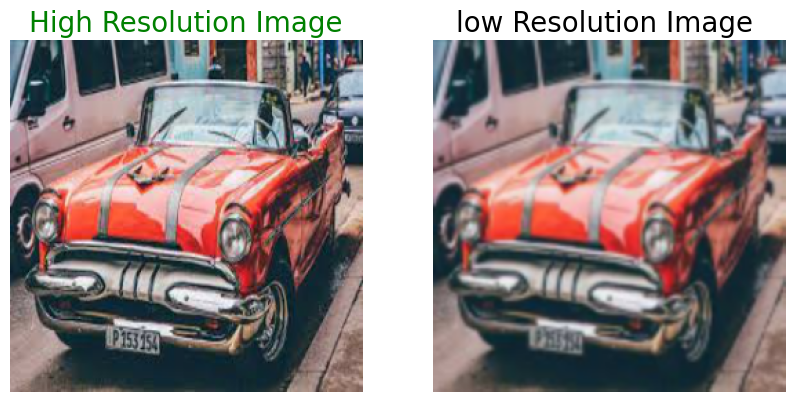

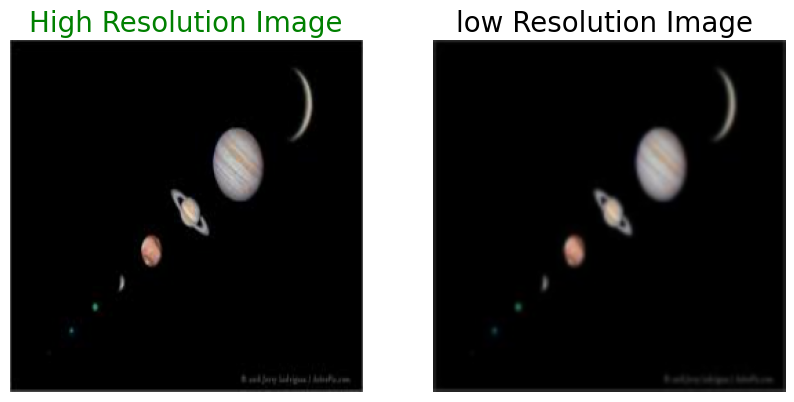

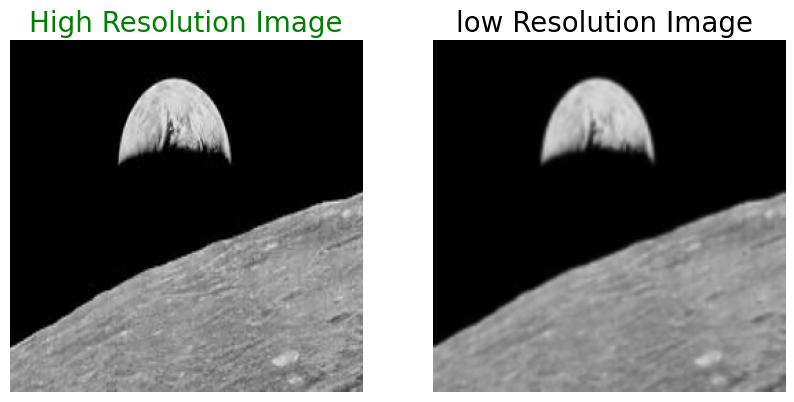

In [7]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [8]:
low_img = np.array(low_img)
high_img = np.array(high_img)
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
low_res_dir = os.path.join(augmented_dir, 'low_res')
high_res_dir = os.path.join(augmented_dir, 'high_res')

os.makedirs(low_res_dir, exist_ok=True)
os.makedirs(high_res_dir, exist_ok=True)

In [10]:
# Function to augment and save images
def augment_and_save_images(images, save_dir, prefix, count=5):
    for idx, img in enumerate(tqdm(images, desc=f"Augmenting {prefix} images")):
        img = img.reshape((1,) + img.shape)  # Reshape to (1, SIZE, SIZE, 3) for ImageDataGenerator
        save_prefix = f"{prefix}_{idx}"
        save_path = os.path.join(save_dir, save_prefix)
        aug_iter = datagen.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format='png')
        for _ in range(count):
            next(aug_iter)  # Generate and save the specified number of augmented images




In [11]:
# Augment and save low-resolution images
augment_and_save_images(low_img, low_res_dir, prefix="low_res", count=5)

# Augment and save high-resolution images
augment_and_save_images(high_img, high_res_dir, prefix="high_res", count=5)

print("Augmentation complete and images saved.")

Augmenting high_res images: 100%|██████████| 855/855 [04:33<00:00,  3.12it/s]

Augmentation complete and images saved.


In [12]:
# Directory to save denoised images
denoised_low_res_dir = os.path.join(augmented_dir, 'denoised_low_res')
os.makedirs(denoised_low_res_dir, exist_ok=True)

# Function to apply Gaussian denoising
def apply_gaussian_denoising(input_dir, output_dir, kernel_size=(5, 5), sigma=1):
    # List all files in the input directory
    files = os.listdir(input_dir)
    files = sorted_alphanumeric(files)
    
    for file in tqdm(files, desc="Applying Gaussian Denoising"):
        # Load the image
        file_path = os.path.join(input_dir, file)
        img = cv2.imread(file_path)
        
        # Apply Gaussian Blur (denoising)
        denoised_img = cv2.GaussianBlur(img, kernel_size, sigma)
        
        # Save the denoised image
        save_path = os.path.join(output_dir, file)
        cv2.imwrite(save_path, denoised_img)

# Apply Gaussian denoising to augmented low-resolution images
apply_gaussian_denoising(low_res_dir, denoised_low_res_dir, kernel_size=(5, 5), sigma=1)

print("Gaussian denoising applied and images saved.")


Applying Gaussian Denoising: 100%|██████████| 4275/4275 [02:02<00:00, 34.86it/s]

Gaussian denoising applied and images saved.


In [13]:
augmented_images_low_res = []
augmented_images_high_res = []

augmented_images_low_res = np.array(augmented_images_low_res)
augmented_images_high_res = np.array(augmented_images_high_res)

# Print the number of original and augmented images
print(f"Original low-resolution images: {low_img.shape[0]}")
print(f"Augmented low-resolution images: {augmented_images_low_res.shape[0]}")
print(f"Original high-resolution images: {high_img.shape[0]}")
print(f"Augmented high-resolution images: {augmented_images_high_res.shape[0]}")

Original low-resolution images: 855
Augmented low-resolution images: 0
Original high-resolution images: 855
Augmented high-resolution images: 0


In [14]:
augmented_images_low_res = []
augmented_images_high_res = []

for i, (low, high) in enumerate(zip(low_img, high_img)):
    # Augmenting low-resolution images
    low = np.expand_dims(low, axis=0)  # Reshape for datagen
    it_low = datagen.flow(low, batch_size=1)
    
    for j in range(5):  # Generate 5 augmented images per low-res image
        augmented_low = next(it_low)[0]
        augmented_images_low_res.append(augmented_low)

        # Convert and save the augmented low-res images
        low_res_path = os.path.join(low_res_dir, f'low_img_{i+1}_{j+1}.png')
        if augmented_low.dtype != np.uint8:
            augmented_low = (augmented_low * 255).astype(np.uint8)
        cv2.imwrite(low_res_path, augmented_low)

    # Augmenting high-resolution images (using the same datagen or another approach)
    high = np.expand_dims(high, axis=0)  # Reshape for datagen
    it_high = datagen.flow(high, batch_size=1)
    
    for j in range(5):  # Generate 5 augmented images per high-res image
        augmented_high = next(it_high)[0]
        augmented_images_high_res.append(augmented_high)

        # Convert and save the augmented high-res images
        high_res_path = os.path.join(high_res_dir, f'high_img_{i+1}_{j+1}.png')
        if augmented_high.dtype != np.uint8:
            augmented_high = (augmented_high * 255).astype(np.uint8)
        cv2.imwrite(high_res_path, augmented_high)

# Convert the augmented images to numpy arrays
augmented_images_low_res = np.array(augmented_images_low_res)
augmented_images_high_res = np.array(augmented_images_high_res)

# Print the number of original and augmented images
print(f"Original low-resolution images: {low_img.shape[0]}")
print(f"Augmented low-resolution images: {augmented_images_low_res.shape[0]}")
print(f"Original high-resolution images: {high_img.shape[0]}")
print(f"Augmented high-resolution images: {augmented_images_high_res.shape[0]}")

Original low-resolution images: 855
Augmented low-resolution images: 4275
Original high-resolution images: 855
Augmented high-resolution images: 4275


In [16]:
augmented_low_images = []
for img in low_img:
    img = np.expand_dims(img, axis=0)  
    it = datagen.flow(img, batch_size=1)
    for _ in range(5): 
        augmented_low_images.append(next(it)[0]) 

augmented_low_images = np.array(augmented_low_images)

print(f"Original images: {low_img.shape[0]}")
print(f"Augmented images: {augmented_low_images.shape[0]}")


MemoryError: Unable to allocate 3.13 GiB for an array with shape (4275, 256, 256, 3) and data type float32

In [ ]:
augmented_high_images = []
for img in high_img:
    img = np.expand_dims(img, axis=0)  
    it = datagen.flow(img, batch_size=1)
    for _ in range(5): 
        augmented_high_images.append(next(it)[0]) 

augmented_high_images = np.array(augmented_high_images)

print(f"Original images: {high_img.shape[0]}")
print(f"Augmented images: {augmented_high_images.shape[0]}")


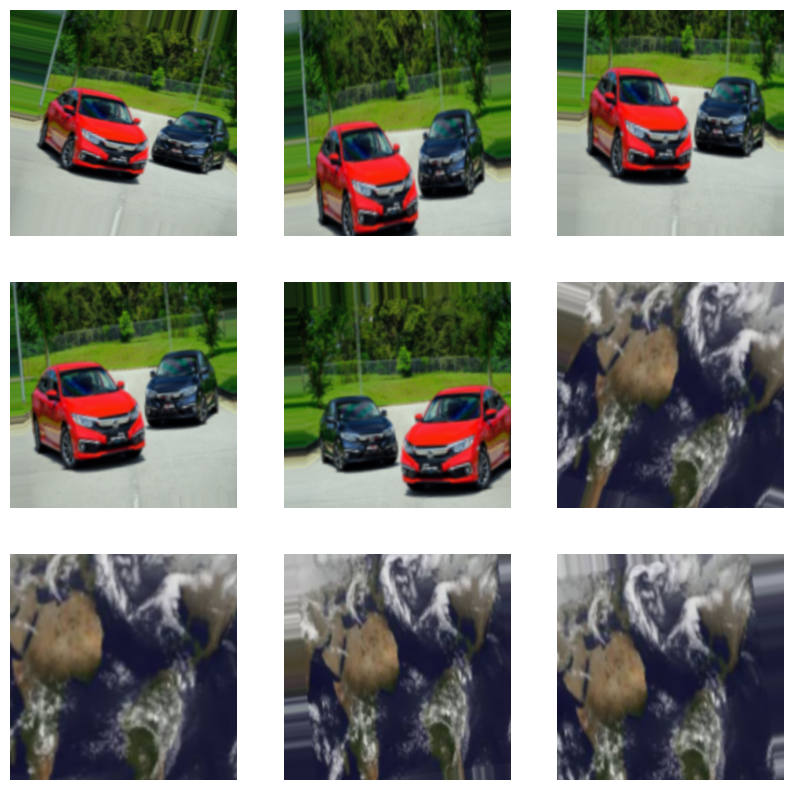

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


NameError: name 'x' is not defined